In [175]:
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [2]:
# загружаю данные

In [3]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [4]:
train_pd = pd.DataFrame(train)

In [5]:
train_pd[0].value_counts(normalize = True)

1.0    0.111524
7.0    0.104786
3.0    0.103595
9.0    0.099714
2.0    0.099452
6.0    0.098500
0.0    0.098381
4.0    0.096952
8.0    0.096738
5.0    0.090357
Name: 0, dtype: float64

In [6]:
y = train[:, 0]

In [7]:
X_0 = train[:, 1:]

In [8]:
# попробую метод опорных векторов без какой-либо предобработки данных

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_0, y, test_size = 0.3, random_state = 20)

In [10]:
clf = LinearSVC(C=1.0)
clf.fit(X_train, y_train)

/Users/lera/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [11]:
clf.score(X_train, y_train)

0.8831972789115646

In [12]:
accuracy_score(y_test, clf.predict(X_test)) 

0.8532539682539683

In [14]:
y_pred_test = clf.predict(test)
y_pred_test = y_pred_test.astype(int)

In [15]:
with open('submit_only_svc.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
#Your submission scored 0.85271

In [16]:
# теперь посмотрю, какие результаты получатся, если сделать гистограмму направленных градиентов

In [17]:
train.shape

(42000, 785)

In [18]:
(785 - 1)**(1/2)

28.0

In [19]:
y = train[:, 0]

In [20]:
X = np.resize(train[:, 1:], (train.shape[0], 28, 28))

In [21]:
test.shape

(28000, 784)

In [22]:
test = np.resize(test, (test.shape[0], 28, 28))

In [23]:
#посмотрим на картинки, которые получила

In [24]:
#для трейна

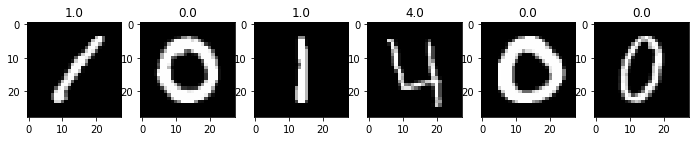

In [25]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(X[0:6], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y[i - 1]);

In [26]:
# для теста

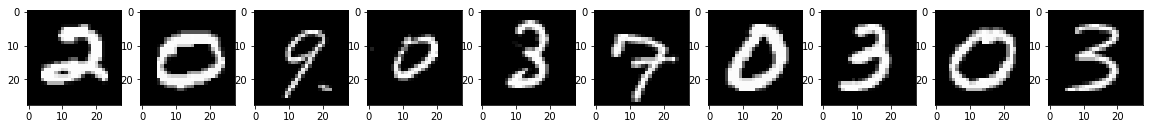

In [27]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    

In [28]:
# Вычисляю составляющие градиента по осям x, y с помощью оператора Собеля, размер ядра фильтра равен 3

In [29]:
cv2.Sobel?

In [30]:
train_sobel_x = np.zeros_like(X)
train_sobel_y = np.zeros_like(X)

for i in range(len(X)):
    train_sobel_x[i] = cv2.Sobel(X[i], cv2.CV_64F, 1, 0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(X[i], cv2.CV_64F, 0, 1, ksize=3)
    
    

In [31]:
test_sobel_x = np.zeros_like(test)
test_sobel_y = np.zeros_like(test)
for i in range(len(test)):
    test_sobel_x[i] = cv2.Sobel(test[i], cv2.CV_64F, 1, 0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test[i], cv2.CV_64F, 0, 1, ksize=3)

In [32]:
# определяю направление и длину вектора градиента

In [33]:
train_magnitude, train_angle = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [34]:
test_magnitude, test_angle = cv2.cartToPolar(test_sobel_x, test_sobel_y)

In [35]:
#визуализирую их

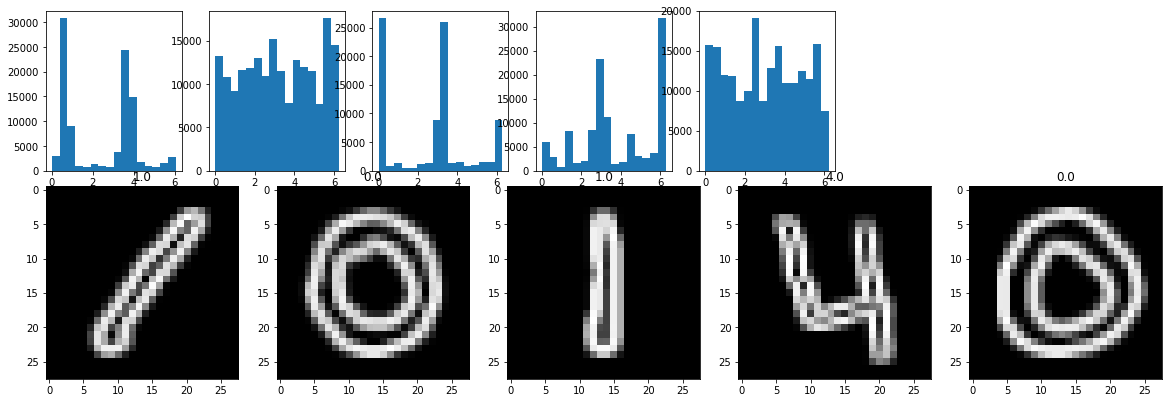

In [36]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_magnitude[:5], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_angle[i - 1].flatten(),
             bins=16, weights=train_magnitude[i - 1].flatten())

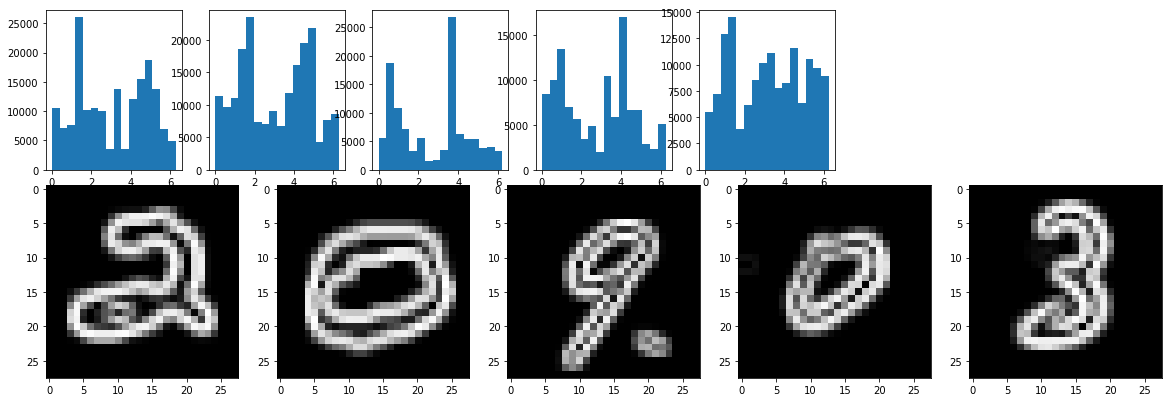

In [37]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_magnitude[:5], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img, cmap='gray');
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(test_angle[i - 1].flatten(),
             bins=16, weights=test_magnitude[i - 1].flatten())

In [ ]:
# оцениваю гистрограмму градиентов

In [ ]:
np.histogram?

In [60]:
np.bincount?

In [39]:
X[0].shape

(28, 28)

In [ ]:
#делю картинку на 16 частей (разбиение на части регулируется параметрами cellx и celly) и для каждой части вычисляю гистограмму

In [90]:
def hist(X, magnitude, angle, bins = 16, cellx = 7, celly = 7):
    bin = np.int32(bins*angle/(2*np.pi))
    b = []
    m = []
    for i in range(0, int(X.shape[1]/celly)):
        for j in range (0, int(X.shape[2]/cellx)):
            b.append(bin[i*celly : celly*(i+1), j*cellx : cellx*(i+1)])
            m.append(magnitude[i*celly : celly*(i+1), j*cellx : cellx*(i+1)])
    hists = [np.bincount(a.ravel(), b.ravel(), bins) for a, b in zip(b, m)]
    hist = np.hstack(hists)
    return hist
    

In [91]:
a = []
for magnitude, angle in zip(train_magnitude, train_angle):
    a.append (hist (X, magnitude, angle))
train_hist = np.stack(a)

In [92]:
train_hist.shape

(42000, 256)

In [93]:
train_hist

array([[  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       , 149.1185234,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ]])

In [94]:
b = []
for magnitude, angle in zip(test_magnitude, test_angle):
    b.append (hist (X, magnitude, angle))
test_hist = np.stack(b)

In [95]:
test_hist.shape

(28000, 256)

In [96]:
test_hist

array([[  0.        ,   0.        ,   0.        , ..., 457.61118867,
         19.79898987,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 39.84971769,  18.38477631,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [ ]:
#нормирую полученные гистограммы, чтобы вектор был единичной длины

In [97]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [99]:
train_hist

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00411653, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [100]:
#теперь можно приступить непосредственно к самой классификации

In [101]:
X_train, X_test, y_train, y_test = train_test_split(train_hist, y, test_size = 0.3, random_state = 20)

In [102]:
X_train.shape

(29400, 256)

In [103]:
clf = LinearSVC(C=1.0)
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [104]:
clf.score(X_train, y_train)

0.9368367346938775

In [105]:
accuracy_score(y_test, clf.predict(X_test)) 

0.9305555555555556

In [108]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      1241
         1.0       0.97      0.98      0.98      1421
         2.0       0.92      0.94      0.93      1250
         3.0       0.93      0.93      0.93      1321
         4.0       0.93      0.90      0.92      1188
         5.0       0.89      0.85      0.87      1158
         6.0       0.94      0.95      0.95      1185
         7.0       0.94      0.95      0.94      1324
         8.0       0.93      0.92      0.92      1245
         9.0       0.91      0.88      0.90      1267

   micro avg       0.93      0.93      0.93     12600
   macro avg       0.93      0.93      0.93     12600
weighted avg       0.93      0.93      0.93     12600



In [106]:
y_pred_test = clf.predict(test_hist)
y_pred_test = y_pred_test.astype(int)

In [107]:
with open('submit_16_16_svc.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
#Your submission scored 0.93257

In [ ]:
#результат стал уже лучше 

In [109]:
#попробую разделить картинку на 49 частей

In [129]:
a = []
for magnitude, angle in zip(train_magnitude, train_angle):
    a.append (hist (X, magnitude, angle, cellx = 4, celly = 4))
train_hist = np.stack(a)

In [130]:
train_hist.shape

(42000, 784)

In [131]:
b = []
for magnitude, angle in zip(test_magnitude, test_angle):
    b.append (hist (X, magnitude, angle, cellx = 4, celly = 4))
test_hist = np.stack(b)

In [132]:
test_hist.shape

(28000, 784)

In [133]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [134]:
X_train, X_test, y_train, y_test = train_test_split(train_hist, y, test_size = 0.3, random_state = 20)

In [135]:
clf = LinearSVC(C=1.0)
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [136]:
clf.score(X_train, y_train)

0.9521428571428572

In [137]:
accuracy_score(y_test, clf.predict(X_test)) 

0.9483333333333334

In [138]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1241
         1.0       0.97      0.98      0.97      1421
         2.0       0.95      0.96      0.95      1250
         3.0       0.95      0.95      0.95      1321
         4.0       0.93      0.91      0.92      1188
         5.0       0.92      0.91      0.92      1158
         6.0       0.96      0.97      0.96      1185
         7.0       0.96      0.96      0.96      1324
         8.0       0.96      0.94      0.95      1245
         9.0       0.91      0.91      0.91      1267

   micro avg       0.95      0.95      0.95     12600
   macro avg       0.95      0.95      0.95     12600
weighted avg       0.95      0.95      0.95     12600



In [139]:
y_pred_test = clf.predict(test_hist)
y_pred_test = y_pred_test.astype(int)

In [140]:
with open('submit_49_16_svc.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
#Your submission scored 0.94728, результат стал уже лучше

In [141]:
# попробую разные значения C 

In [165]:
clf = LinearSVC(C=10, random_state = 20)
clf.fit(X_train, y_train)

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=20, tol=0.0001,
     verbose=0)

In [166]:
clf.score(X_train, y_train)

0.9621768707482993

In [167]:
accuracy_score(y_test, clf.predict(X_test)) 

0.9538095238095238

In [168]:
y_pred_test = clf.predict(test_hist)
y_pred_test = y_pred_test.astype(int)

In [169]:
with open('submit_49_16_svc_10.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [182]:
#Your submission scored 0.95142, результат еще лучше

In [160]:
clf = LinearSVC(C=100, random_state = 20)
clf.fit(X_train, y_train)

/Users/lera/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=20, tol=0.0001,
     verbose=0)

In [161]:
clf.score(X_train, y_train)

0.9670748299319728

In [162]:
accuracy_score(y_test, clf.predict(X_test)) 

0.9553174603174603

In [163]:
y_pred_test = clf.predict(test_hist)
y_pred_test = y_pred_test.astype(int)

In [164]:
with open('submit_49_16_svc_100.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
#Your submission scored 0.95371,

In [156]:
clf = LinearSVC(C=1e3, random_state = 20)
clf.fit(X_train, y_train)

/Users/lera/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1000.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=20, tol=0.0001,
     verbose=0)

In [157]:
clf.score(X_train, y_train)

0.9609183673469388

In [158]:
accuracy_score(y_test, clf.predict(X_test)) 

0.9482539682539682

In [159]:
with open('submit_49_16_svc_e3.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [183]:
#Your submission scored 0.95257

In [170]:
clf = SVC(C = 5e4,   random_state = 20)
clf.fit(X_train, y_train)

/Users/lera/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=50000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=20,
  shrinking=True, tol=0.001, verbose=False)

In [171]:
clf.score(X_train, y_train)

0.9858503401360544

In [172]:
accuracy_score(y_test, clf.predict(X_test)) 

0.9566666666666667

In [173]:
y_pred_test = clf.predict(test_hist)
y_pred_test = y_pred_test.astype(int)

In [174]:
with open('submit_49_16_svc_5e4.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
#Your submission scored 0.95728, результат стал еще лучше

Можно дальше пробовать изменять параметры, например, изменить размер ядра фильтра оператора Собеля, также картинку можно делить на большее количество частей. Но в целом, результат при использование гистограммы направленных градиентов стал лучше, нежели получился без обработки данных. 0.85271 на Kaggle без обработки и 0.95728 при делении картинки на 49 частей, bins = 16, SVC(C = 5e4,   random_state = 20)

In [184]:
train_sobel_1_x = np.zeros_like(X)
train_sobel_1_y = np.zeros_like(X)

for i in range(len(X)):
    train_sobel_1_x[i] = cv2.Sobel(X[i], cv2.CV_64F, 1, 0, ksize=5)
    train_sobel_1_y[i] = cv2.Sobel(X[i], cv2.CV_64F, 0, 1, ksize=5)


In [185]:
test_sobel_1_x = np.zeros_like(test)
test_sobel_1_y = np.zeros_like(test)
for i in range(len(test)):
    test_sobel_1_x[i] = cv2.Sobel(test[i], cv2.CV_64F, 1, 0, ksize=5)
    test_sobel_1_y[i] = cv2.Sobel(test[i], cv2.CV_64F, 0, 1, ksize=5)

In [186]:
train_magnitude, train_angle = cv2.cartToPolar(train_sobel_1_x, train_sobel_1_y)

In [187]:
test_magnitude, test_angle = cv2.cartToPolar(test_sobel_1_x, test_sobel_1_y)

In [188]:
a = []
for magnitude, angle in zip(train_magnitude, train_angle):
    a.append (hist (X, magnitude, angle))
train_hist = np.stack(a)

In [189]:
b = []
for magnitude, angle in zip(test_magnitude, test_angle):
    b.append (hist (X, magnitude, angle))
test_hist = np.stack(b)

In [190]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [192]:
X_train, X_test, y_train, y_test = train_test_split(train_hist, y, test_size = 0.3, random_state = 20)

In [193]:
clf = LinearSVC(C=1.0)
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [194]:
clf.score(X_train, y_train)

0.9426530612244898

In [195]:
accuracy_score(y_test, clf.predict(X_test)) 

0.9387301587301587

In [196]:
y_pred_test = clf.predict(test_hist)
y_pred_test = y_pred_test.astype(int)

In [197]:
with open('submit_49_16_svc_1_sobel_5.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [198]:
#Your submission scored 0.94085, результат стал немного хуже, чем в случае, когда размер ядра был равен 3